In [4]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!unzip /content/drive/MyDrive/household_power_consumption.zip

Archive:  /content/drive/MyDrive/household_power_consumption.zip
  inflating: household_power_consumption.txt  


In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


In [57]:
# Prepare the data
data = pd.read_csv('/content/household_power_consumption.txt', delimiter=';', 
                   parse_dates={'datetime': ['Date', 'Time']}, 
                   infer_datetime_format=True, 
                   low_memory=False, na_values=['nan','?'])
data.dropna(inplace=True)
data.set_index('datetime', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
seq_length = 30 # length of input sequence
n_features = scaled_data.shape[1] # number of features
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

In [58]:
# Define the training dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.seq_length, :]
        y = self.data[idx+self.seq_length, 0]
        return torch.FloatTensor(x), torch.FloatTensor([y])
train_dataset = TimeSeriesDataset(train_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TimeSeriesDataset(test_data, seq_length)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [59]:
for inputs, labels in train_loader:
    print("Inputs shape:", inputs.shape)
    print("Labels shape:", labels.shape)
    break


Inputs shape: torch.Size([64, 30, 7])
Labels shape: torch.Size([64, 1])


In [60]:
# Define the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(n_features, 64, 1, 2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, epochs, running_loss/len(train_loader)))

Epoch [1/10], Loss: 0.0006
Epoch [2/10], Loss: 0.0005
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004


In [61]:
# Evaluate the model on the testing data
model.eval()
predictions_82 = []
labels = []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs)
        predictions_82.append(output.cpu().numpy())
        labels.append(target.cpu().numpy())

predictions_82 = np.concatenate(predictions_82, axis=0)
labels = np.concatenate(labels, axis=0)


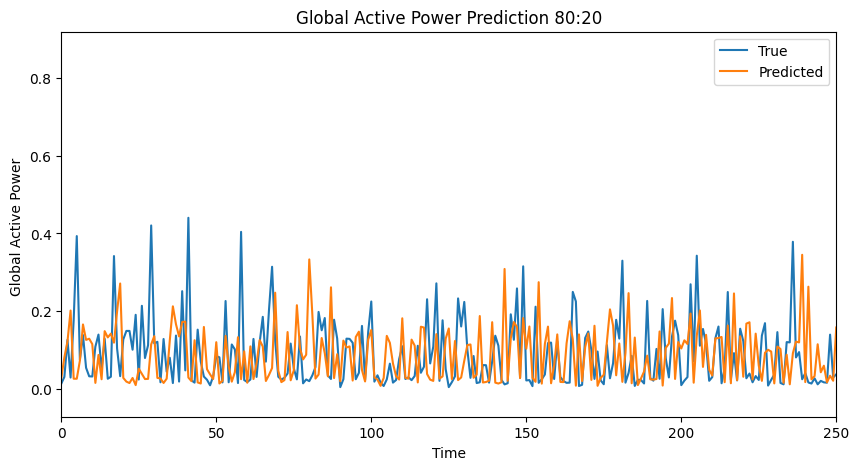

In [71]:
# Plot the real and predicted global active power for the testing days
plt.figure(figsize=(10, 5))
plt.plot(labels[:, 0], label='True')
plt.plot(predictions_82[:, 0], label='Predicted')
plt.title('Global Active Power Prediction 80:20')
plt.xlabel('Time')
plt.ylabel('Global Active Power ')
plt.xlim([0, 250])
plt.legend()
plt.show()


### 70:30

In [63]:
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

train_dataset = TimeSeriesDataset(train_data, seq_length)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TimeSeriesDataset(test_data, seq_length)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [64]:
# Define the model and training parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(n_features, 64, 1, 2).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 10

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch [%d/%d], Loss: %.4f' % (epoch+1, epochs, running_loss/len(train_loader)))

Epoch [1/10], Loss: 0.0006
Epoch [2/10], Loss: 0.0005
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0005
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0004
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0004
Epoch [10/10], Loss: 0.0004


In [65]:
# Evaluate the model on the testing data
model.eval()
predictions_73 = []
labels = []
with torch.no_grad():
    for inputs, target in test_loader:
        inputs, target = inputs.to(device), target.to(device)
        output = model(inputs)
        predictions_73.append(output.cpu().numpy())
        labels.append(target.cpu().numpy())

predictions_73 = np.concatenate(predictions_73, axis=0)
labels = np.concatenate(labels, axis=0)


In [70]:
# Plot the real and predicted global active power for the testing days
plt.figure(figsize=(10, 5))
plt.plot(labels[:, 0], label='True')
plt.plot(predictions_73[:, 0], label='Predicted')
plt.title('Global Active Power Prediction 70:30')
plt.xlabel('Time')
plt.ylabel('Global Active Power')
plt.xlim([0, 250])
plt.legend()
plt.show()


### Comparison

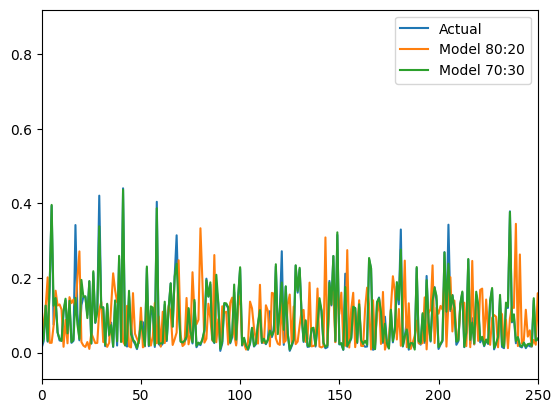

In [73]:
plt.plot(labels[:, 0], label='Actual')
plt.plot(predictions_82[:, 0], label='Model 80:20')
plt.plot(predictions_73[:, 0], label='Model 70:30')

plt.xlim([0, 250])

plt.legend()
plt.show()